# Data Bootcamp Project: Sales Price Relationship between Crime, SAT Scores, Health Centers and # of train stations by Borough
## By Ashmeet Khanooja, Cheryl Li, Chris Chan

# Background

We wanted to explore the relationship that crime rates, SAT scores, and the # of health centers and train stations within proximity of a property affected the sales price.

# Data

Sales Data: http://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page. This data set gave us access to Manhattan sales from November 2016 to October 2017.

Crime Data: http://data.beta.nyc/dataset/nypd. This data set gave us access to crime instances.

SAT Scores: https://www.kaggle.com/nycopendata/high-schools. SAT scores in NYC Public Schools from 2014-2015 academic year.

Health Center Data: https://data.cityofnewyork.us/Health/NYC-Health-and-Hospitals-Corporation-Facilities/ymhw-9cz9. This contained location information for health centers in NYC.

Subway Station Data: https://data.ny.gov/Transportation/NYC-Transit-Subway-Entrance-And-Exit-Data/i9wp-a4ja. This data provided the coordinates for stations in New York.


# Data Packages

In [1]:
# Importing packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys                             
import requests
from geopy.geocoders import Nominatim
import folium
import seaborn as sns
from pprint import pprint
from folium import plugins


# IPython command, puts plots in notebook 
%matplotlib inline

# Cleaning the Sales Data

In [2]:
#All csv files were saved in github for ease of access
url = 'https://raw.githubusercontent.com/chrisc617/Data-Bootcamp-Final-Project/master/rollingsales_manhattan%20Clean.csv'
sales = pd.read_csv(url, sep=',')
print(sales.shape)
sales.columns=[i.strip().lower() for i in sales.columns]
sales = sales.drop(sales[['block','lot','ease-ment','building class at present','tax class at time of sale','building class at time of sale']],axis=1)
sales.head()

(18066, 21)


,borough,neighborhood,building class category,tax class at present,address,apartment number,zip code,residential units,commercial units,total units,land square feet,gross square feet,year built,sale price,sale date
0,1,ALPHABET CITY,03 THREE FAMILY DWELLINGS,1,264 EAST 7TH STREET,,10009,3,0,3,"2,059","3,696",1900,"7,738,700",12/22/2016
1,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,738 EAST 6TH STREET,,10009,11,0,11,"1,750","6,500",1900,"3,750,000",4/3/2017
2,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,27 AVENUE C,,10009,24,1,25,"2,650","9,960",1910,"5,235,000",7/11/2017
3,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,151 AVENUE B,,10009,5,0,5,"2,139","4,416",1900,-,6/16/2017
4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,153 AVENUE B,,10009,5,0,5,"1,633","6,440",1900,"6,625,000",7/19/2017


In [3]:
#Cleaning up values within the sale price column
sales['sale price'].value_counts(dropna=False)
sales['sale price'] = sales['sale price'].replace(to_replace=[' -   '], value=[None])
sales['sale price'].value_counts(dropna=False)
sales=sales.dropna()

In [4]:
#Reformatting more columns
sales[['zip code','borough']] = sales[['zip code','borough']].astype(str)
sales['sale price'] = sales['sale price'].apply(lambda x: x.replace(',',''))
sales.head()
sales[['sale price']] = sales[['sale price']].astype(float)
sales.head()

,borough,neighborhood,building class category,tax class at present,address,apartment number,zip code,residential units,commercial units,total units,land square feet,gross square feet,year built,sale price,sale date
0,1,ALPHABET CITY,03 THREE FAMILY DWELLINGS,1,264 EAST 7TH STREET,,10009,3,0,3,"2,059","3,696",1900,7738700.0,12/22/2016
1,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,738 EAST 6TH STREET,,10009,11,0,11,"1,750","6,500",1900,3750000.0,4/3/2017
2,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,27 AVENUE C,,10009,24,1,25,"2,650","9,960",1910,5235000.0,7/11/2017
4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,153 AVENUE B,,10009,5,0,5,"1,633","6,440",1900,6625000.0,7/19/2017
7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,301 EAST 10TH STREET,,10009,6,0,6,"2,369","4,615",1900,8000000.0,11/17/2016


In [5]:
#Removing any building classes that are not meant for housing (i.e. office buildings, stores, etc.)
sales['building class category'] = sales['building class category'].apply(lambda x: x.strip())
sales =sales.loc[sales['building class category'].isin(['13  CONDOS - ELEVATOR APARTMENTS','07  RENTALS - WALKUP APARTMENTS','10  COOPS - ELEVATOR APARTMENTS','17  CONDO COOPS','09  COOPS - WALKUP APARTMENTS',
                                                 '15  CONDOS - 2-10 UNIT RESIDENTIAL','08  RENTALS - ELEVATOR APARTMENTS','01  ONE FAMILY DWELLINGS','02  TWO FAMILY DWELLINGS','12  CONDOS - WALKUP APARTMENTS'
                                                 ,'45  CONDO HOTELS','03  THREE FAMILY DWELLINGS','14  RENTALS - 4-10 UNIT','16  CONDOS - 2-10 UNIT WITH COMMERCIAL UNIT', '11A  CONDO RENTALS'])]
sales.head()

,borough,neighborhood,building class category,tax class at present,address,apartment number,zip code,residential units,commercial units,total units,land square feet,gross square feet,year built,sale price,sale date
0,1,ALPHABET CITY,03 THREE FAMILY DWELLINGS,1,264 EAST 7TH STREET,,10009,3,0,3,"2,059","3,696",1900,7738700.0,12/22/2016
1,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,738 EAST 6TH STREET,,10009,11,0,11,"1,750","6,500",1900,3750000.0,4/3/2017
2,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,27 AVENUE C,,10009,24,1,25,"2,650","9,960",1910,5235000.0,7/11/2017
4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,153 AVENUE B,,10009,5,0,5,"1,633","6,440",1900,6625000.0,7/19/2017
7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,301 EAST 10TH STREET,,10009,6,0,6,"2,369","4,615",1900,8000000.0,11/17/2016


In [88]:
sales[['sale price']] = sales[['sale price']].astype(float)
sales=sales[sales['sale price']>100]
sales.head()

,borough,neighborhood,building class category,tax class at present,address,apartment number,zip code,residential units,commercial units,total units,land square feet,gross square feet,year built,sale price,sale date
0,1,ALPHABET CITY,03 THREE FAMILY DWELLINGS,1,264 EAST 7TH STREET,,10009,3,0,3,"2,059","3,696",1900,7738700.0,12/22/2016
1,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,738 EAST 6TH STREET,,10009,11,0,11,"1,750","6,500",1900,3750000.0,4/3/2017
2,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,27 AVENUE C,,10009,24,1,25,"2,650","9,960",1910,5235000.0,7/11/2017
4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,153 AVENUE B,,10009,5,0,5,"1,633","6,440",1900,6625000.0,7/19/2017
7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,301 EAST 10TH STREET,,10009,6,0,6,"2,369","4,615",1900,8000000.0,11/17/2016


# SAT Scores

In [7]:
#Retrieving csv for our SAT data and dropping unecessary columns from the dataframe
url = 'https://github.com/chrisc617/Data-Bootcamp-Final-Project/raw/master/scores.csv'
sat = pd.read_csv(url, sep=',')
print(sat.shape)
sat.head()
sat.columns=[i.lower() for i in sat.columns]
sat.drop(sat[['city','building code','state','phone number','start time','end time','student enrollment','percent tested']],axis=1)
sat = sat.drop(sat[['city','building code','state','phone number','start time','end time','student enrollment','percent tested']],axis=1)

(435, 22)


In [8]:
#Removing duplicate values
sat_m = sat[sat['borough']=='Manhattan']
print(sat_m.shape)
sat_m.dropna()
sat_m = sat_m.dropna()
sat_m.drop_duplicates(['school id'])
sat_m = sat_m.drop_duplicates(['school id'])
print(sat_m.shape)
sat_m['zip code'] = sat_m['zip code'].astype(str)
print(sat_m.dtypes)
sat_m.head()

(106, 14)
(89, 14)
school id                       object
school name                     object
borough                         object
street address                  object
zip code                        object
latitude                       float64
longitude                      float64
percent white                   object
percent black                   object
percent hispanic                object
percent asian                   object
average score (sat math)       float64
average score (sat reading)    float64
average score (sat writing)    float64
dtype: object


,school id,school name,borough,street address,zip code,latitude,longitude,percent white,percent black,percent hispanic,percent asian,average score (sat math),average score (sat reading),average score (sat writing)
2,01M539,"New Explorations into Science, Technology and ...",Manhattan,111 Columbia Street,10002,40.71873,-73.97943,28.6%,13.3%,18.0%,38.5%,657.0,601.0,601.0
3,02M294,Essex Street Academy,Manhattan,350 Grand Street,10002,40.71687,-73.98953,11.7%,38.5%,41.3%,5.9%,395.0,411.0,387.0
4,02M308,Lower Manhattan Arts Academy,Manhattan,350 Grand Street,10002,40.71687,-73.98953,3.1%,28.2%,56.9%,8.6%,418.0,428.0,415.0
5,02M545,High School for Dual Language and Asian Studies,Manhattan,350 Grand Street,10002,40.71687,-73.98953,1.7%,3.1%,5.5%,88.9%,613.0,453.0,463.0
6,01M292,Henry Street School for International Studies,Manhattan,220 Henry Street,10002,40.71376,-73.98526,3.9%,24.4%,56.6%,13.2%,410.0,406.0,381.0


In [9]:
#Map
sat_m['latitude']
lat1=(sat_m['latitude'][2])
lon1=(sat_m['longitude'][2])

sat_m_geo=sat_m[['latitude','longitude']]
sat_m_geo.head()

map_sat_m = folium.Map(location=[lat1,lon1], zoom_start=12)
for lat, lon in zip(sat_m_geo.latitude, sat_m_geo.longitude):
    folium.Marker(location=[lat,lon]).add_to(map_sat_m)

map_sat_m

In [10]:
#Creating a new column to find the average of the total SAT score
sat_m = sat_m.rename(columns = {'average score (sat math)':'math','average score (sat reading)':'reading','average score (sat writing)':'writing'})
sat_m['average score overall'] = sat_m['math'] + sat_m['reading'] + sat_m['writing']
sat_m.sort_values('average score overall',ascending=False).head()

,school id,school name,borough,street address,zip code,latitude,longitude,percent white,percent black,percent hispanic,percent asian,math,reading,writing,average score overall
105,02M475,Stuyvesant High School,Manhattan,345 Chambers Street,10282,40.71775,-74.01405,20.4%,0.8%,2.6%,73.4%,754.0,697.0,693.0,2144.0
7,01M696,Bard High School Early College,Manhattan,525 East Houston Street,10002,40.71896,-73.97607,45.3%,17.2%,18.7%,17.1%,634.0,641.0,639.0,1914.0
80,05M692,"High School for Mathematics, Science, and Engi...",Manhattan,240 Convent Avenue,10031,40.82112,-73.94885,26.8%,9.6%,21.7%,38.5%,683.0,610.0,596.0,1889.0
55,02M416,Eleanor Roosevelt High School,Manhattan,411 East 76th Street,10021,40.77012,-73.95338,61.4%,4.4%,10.9%,20.1%,641.0,617.0,631.0,1889.0
2,01M539,"New Explorations into Science, Technology and ...",Manhattan,111 Columbia Street,10002,40.71873,-73.97943,28.6%,13.3%,18.0%,38.5%,657.0,601.0,601.0,1859.0


In [11]:
sat_m.head()

,school id,school name,borough,street address,zip code,latitude,longitude,percent white,percent black,percent hispanic,percent asian,math,reading,writing,average score overall
2,01M539,"New Explorations into Science, Technology and ...",Manhattan,111 Columbia Street,10002,40.71873,-73.97943,28.6%,13.3%,18.0%,38.5%,657.0,601.0,601.0,1859.0
3,02M294,Essex Street Academy,Manhattan,350 Grand Street,10002,40.71687,-73.98953,11.7%,38.5%,41.3%,5.9%,395.0,411.0,387.0,1193.0
4,02M308,Lower Manhattan Arts Academy,Manhattan,350 Grand Street,10002,40.71687,-73.98953,3.1%,28.2%,56.9%,8.6%,418.0,428.0,415.0,1261.0
5,02M545,High School for Dual Language and Asian Studies,Manhattan,350 Grand Street,10002,40.71687,-73.98953,1.7%,3.1%,5.5%,88.9%,613.0,453.0,463.0,1529.0
6,01M292,Henry Street School for International Studies,Manhattan,220 Henry Street,10002,40.71376,-73.98526,3.9%,24.4%,56.6%,13.2%,410.0,406.0,381.0,1197.0


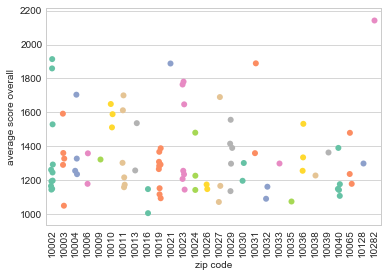

In [12]:
#Visualization
sns.set_style('whitegrid')
ax = sns.stripplot(x='zip code', y='average score overall',
                  data=sat_m, jitter=True,
                  palette='Set2', size=6)
for i in ax.get_xticklabels():
    i.set_rotation(90)

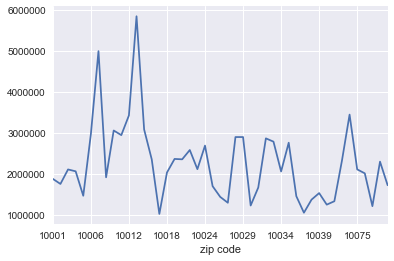

In [89]:
#Visualization
sat1=sat_m[['school id','zip code','average score overall']]
sales1=sales[['address','zip code','sale price','neighborhood']]
sales1['sale price'].value_counts()
sales1.groupby('zip code')['sale price'].mean().plot()

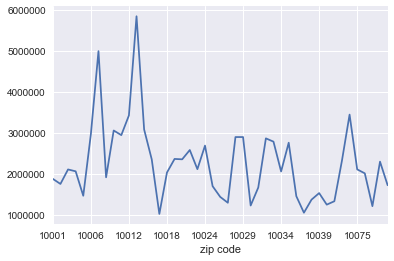

In [90]:
sales1[sales1['sale price']<=1000000000].groupby('zip code')['sale price'].mean().plot()

In [91]:
sat1['count']=1
sales1['count']=1
sat2=sat1.groupby(['zip code'],as_index=False).agg({'average score overall':np.mean,'count':len}).round(2)
sales2=sales1[sales1['sale price']<=1000000000].groupby(['zip code'],as_index=False).agg({'sale price':np.mean,'count':len}).round(2)
# sales3=sales2[sales2['sale price']>10].groupby(['zip code'],as_index=False).agg({'sale price':np.mean,'count':len}).round(2)

/Users/apple/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/apple/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [64]:
combo = pd.merge(sat2,sales2, how='left', left_on = 'zip code', right_on = 'zip code')
combo.rename(columns={'average score overall': 'average_score','sale price':'sale_price'}, inplace=True)
combo

,zip code,average_score,count_x,sale_price,count_y
0,10002,1358.91,11,1751906.80,225
1,10003,1323.60,5,2106426.10,567
2,10004,1380.25,4,2060367.42,72
3,10006,1268.00,2,2968519.74,169
4,10009,1327.00,1,1913669.44,169
5,10010,1583.00,3,3058233.82,427
6,10011,1360.17,6,2945135.47,867
7,10013,1396.50,2,5850517.54,458
8,10016,1076.00,2,2352094.86,782
9,10019,1251.67,9,2363147.86,635


In [17]:
print(combo[['average_score','sale_price']].corr())
import statsmodels.formula.api as smf
print(smf.ols('sale_price ~ average_score' ,data=combo).fit().summary())

               average_score  sale_price
average_score       1.000000    0.070653
sale_price          0.070653    1.000000
                            OLS Regression Results                            
Dep. Variable:             sale_price   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.033
Method:                 Least Squares   F-statistic:                    0.1304
Date:                Thu, 21 Dec 2017   Prob (F-statistic):              0.721
Time:                        17:01:35   Log-Likelihood:                -423.49
No. Observations:                  28   AIC:                             851.0
Df Residuals:                      26   BIC:                             853.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
-----

In [18]:
combo['ln_sale_price']=np.log(combo['sale_price'])
print(smf.ols('ln_sale_price ~ average_score',data=combo).fit().summary())

                            OLS Regression Results                            
Dep. Variable:          ln_sale_price   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                 -0.027
Method:                 Least Squares   F-statistic:                    0.2876
Date:                Thu, 21 Dec 2017   Prob (F-statistic):              0.596
Time:                        17:01:36   Log-Likelihood:                -9.8661
No. Observations:                  28   AIC:                             23.73
Df Residuals:                      26   BIC:                             26.40
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        14.3518      0.419     34.229

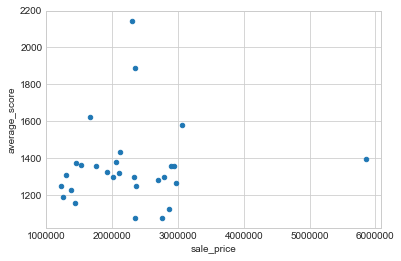

In [19]:
combo.plot(kind='scatter',x='sale_price', y='average_score')

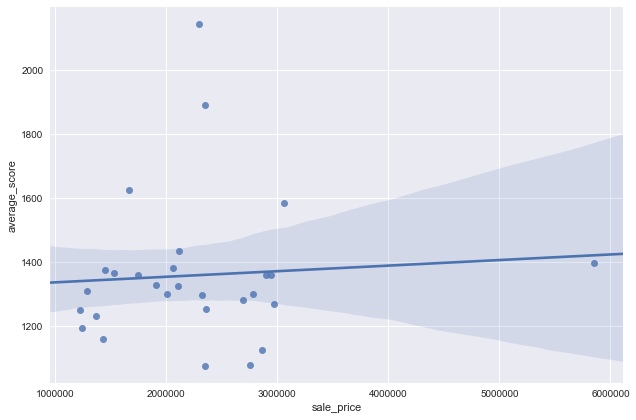

In [20]:
sns.set(color_codes=True)
ax = sns.lmplot(x='sale_price', y='average_score', data=combo, 
                scatter=True, 
                palette='Red', 
                size = 6,
                aspect = 1.5)

# Subway Data

In [21]:
#Retrieving csv file from github
url3 = 'https://raw.githubusercontent.com/chrisc617/Data-Bootcamp'
url4 = '-Final-Project/master/NYC_Transit_Subway_Entrance_And_Exit_Data.csv'
url5 = url3+url4
df=pd.read_csv(url5)
df['geocode_data'] = ''
df['city'] = ''
df['country'] = ''

geolocator = Nominatim()

In [23]:
#defining geocode function
def reverse_geocode(latlng):
    result = {}
    url = 'https://maps.googleapis.com/maps/api/geocode/json?latlng={}'
    request = url.format(latlng)
    data = requests.get(request).json()
    if len(data['results']) > 0:
        result = data['results'][0]
    return result

In [92]:
df.head()

,Division,Line,Station Name,Station Latitude,Station Longitude,Route1,Route2,Route3,Route4,Route5,...,North South Street,East West Street,Corner,Entrance Latitude,Entrance Longitude,Station Location,Entrance Location,geocode_data,city,country
0,BMT,4 Avenue,25th St,40.660397,-73.998091,R,NaN,NaN,NaN,NaN,...,4th Ave,25th St,SE,40.660323,-73.997952,"(40.660397, -73.998091)","(40.660323, -73.997952)",,,
1,BMT,4 Avenue,25th St,40.660397,-73.998091,R,NaN,NaN,NaN,NaN,...,4th Ave,25th St,SW,40.660489,-73.998220,"(40.660397, -73.998091)","(40.660489, -73.998220)",,,
2,BMT,4 Avenue,36th St,40.655144,-74.003549,N,R,NaN,NaN,NaN,...,4th Ave,36th St,NW,40.654490,-74.004499,"(40.655144, -74.003549)","(40.654490, -74.004499)",,,
3,BMT,4 Avenue,36th St,40.655144,-74.003549,N,R,NaN,NaN,NaN,...,4th Ave,36th St,NE,40.654365,-74.004113,"(40.655144, -74.003549)","(40.654365, -74.004113)",,,
4,BMT,4 Avenue,36th St,40.655144,-74.003549,N,R,NaN,NaN,NaN,...,4th Ave,36th St,NW,40.654676,-74.004306,"(40.655144, -74.003549)","(40.654676, -74.004306)",,,


In [25]:
#Pulling only train stations in Brooklyn/Manhattan
dfbmt=df[df['Division'] == 'BMT']
dfbmt.shape

(442, 35)

In [93]:
#Using the geocoder to pull the zip code from coordinates
dfbmt['latlng'] = dfbmt.apply(lambda row: '{},{}'.format(row['Entrance Latitude'], row['Entrance Longitude']), axis=1)
dfbmt['geocode_data'] = dfbmt['latlng'].map(reverse_geocode)
dfbmt['Zip'] =dfbmt['latlng'].apply(geolocator.reverse)
foo = lambda x: pd.Series([i for i in reversed(x.split(','))])
dfbmt['Zip']=dfbmt['Zip'].apply(lambda x: str(x))
dfbmt['Zip']=dfbmt['Zip'].apply(foo)[1]

dfbmt.head()

/Users/apple/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/apple/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/apple/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

,Division,Line,Station Name,Station Latitude,Station Longitude,Route1,Route2,Route3,Route4,Route5,...,Corner,Entrance Latitude,Entrance Longitude,Station Location,Entrance Location,geocode_data,city,country,latlng,Zip
0,BMT,4 Avenue,25th St,40.660397,-73.998091,R,NaN,NaN,NaN,NaN,...,SE,40.660323,-73.997952,"(40.660397, -73.998091)","(40.660323, -73.997952)",{'address_components': [{'long_name': '749-753...,,,"40.660323,-73.997952",11232
1,BMT,4 Avenue,25th St,40.660397,-73.998091,R,NaN,NaN,NaN,NaN,...,SW,40.660489,-73.998220,"(40.660397, -73.998091)","(40.660489, -73.998220)","{'address_components': [{'long_name': '760', '...",,,"40.660489,-73.99821999999999",11232
2,BMT,4 Avenue,36th St,40.655144,-74.003549,N,R,NaN,NaN,NaN,...,NW,40.654490,-74.004499,"(40.655144, -74.003549)","(40.654490, -74.004499)","{'address_components': [{'long_name': '952', '...",,,"40.65449,-74.004499",11232
3,BMT,4 Avenue,36th St,40.655144,-74.003549,N,R,NaN,NaN,NaN,...,NE,40.654365,-74.004113,"(40.655144, -74.003549)","(40.654365, -74.004113)",{'address_components': [{'long_name': '921-937...,,,"40.654365000000006,-74.004113",11232
4,BMT,4 Avenue,36th St,40.655144,-74.003549,N,R,NaN,NaN,NaN,...,NW,40.654676,-74.004306,"(40.655144, -74.003549)","(40.654676, -74.004306)","{'address_components': [{'long_name': '942', '...",,,"40.654676,-74.004306",11232


In [94]:
#Using only the necessary columns for the dataframe
trains=dfbmt[['Line','Station Name','Route1','Zip']]
trains.head()

,Line,Station Name,Route1,Zip
0,4 Avenue,25th St,R,11232
1,4 Avenue,25th St,R,11232
2,4 Avenue,36th St,N,11232
3,4 Avenue,36th St,N,11232
4,4 Avenue,36th St,N,11232


In [95]:
trains['Station Name'].value_counts(dropna=False)
trains=trains.dropna()
trainscount=trains['Zip'].value_counts()
trainscount.head()

 11211    23
 11214    22
 11207    20
 11220    19
 11219    18
Name: Zip, dtype: int64

In [96]:
#Adding a new column to count the number of train stations per zip code
trains['Counts'] = trains.groupby(['Zip'])['Route1'].transform(len)
trains.head()

,Line,Station Name,Route1,Zip,Counts
0,4 Avenue,25th St,R,11232,5
1,4 Avenue,25th St,R,11232,5
2,4 Avenue,36th St,N,11232,5
3,4 Avenue,36th St,N,11232,5
4,4 Avenue,36th St,N,11232,5


In [97]:
#Renaming the columns
trains = trains.rename(columns={'Zip': 'zip code', 'Counts': 'Stations'})
trains['zip code'] = trains['zip code'].apply(lambda x: x.strip())
trains.head()

,Line,Station Name,Route1,zip code,Stations
0,4 Avenue,25th St,R,11232,5
1,4 Avenue,25th St,R,11232,5
2,4 Avenue,36th St,N,11232,5
3,4 Avenue,36th St,N,11232,5
4,4 Avenue,36th St,N,11232,5


In [98]:
#Merging new train dataframe with sales2 dataframe, created during the SAT score analysis
salestrain= pd.merge(sales2, trains, on='zip code')
salestrain=salestrain.drop_duplicates(['zip code'])
# salestrain = pd.merge(trains, sales2, how='right', left_on = 'zip code', right_on = 'zip code')
salestrain.head()

,zip code,sale price,count,Line,Station Name,Route1,Stations
0,10001,1876378.71,155,Broadway,28th St,N,8
8,10002,1751906.80,225,Nassau,Bowery,J,4
12,10003,2106426.10,567,Broadway,8th St,N,15
27,10004,2060367.42,72,Broadway,Whitehall St,R,8
35,10005,1463241.53,171,Nassau,Broad St,J,4


In [99]:
#Using only necessary columns
salestrain=salestrain[['sale price','Stations']]
salestrain.head()

,sale price,Stations
0,1876378.71,8
8,1751906.80,4
12,2106426.10,15
27,2060367.42,8
35,1463241.53,4


In [82]:
#OLS Regression
salestrain['ln_sale_price']=np.log(salestrain['sale price'])
print(smf.ols('ln_sale_price ~ Stations',data=salestrain).fit().summary())

                            OLS Regression Results                            
Dep. Variable:          ln_sale_price   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                 -0.014
Method:                 Least Squares   F-statistic:                    0.7111
Date:                Thu, 21 Dec 2017   Prob (F-statistic):              0.409
Time:                        17:33:39   Log-Likelihood:                -9.7854
No. Observations:                  22   AIC:                             23.57
Df Residuals:                      20   BIC:                             25.75
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     14.5762      0.140    103.883      0.0

/Users/apple/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


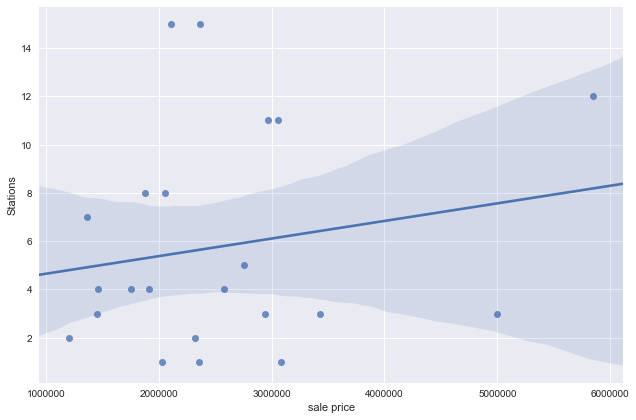

In [137]:
sns.set(color_codes=True)
ax = sns.lmplot(x='sale price', y='Stations', data=salestrain, 
                scatter=True, 
                palette='Red', 
                size = 6,
                aspect = 1.5)

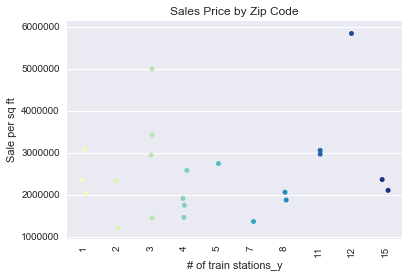

In [83]:
# Plot graph
g = sns.stripplot(x="Stations", 
              y="sale price", 
              data=salestrain,
              palette='YlGnBu',
              jitter=True);

# rotate labels 90 degrees
for item in g.get_xticklabels():
    item.set_rotation(90)

# Add title and labels
plt.title('Sales Price by Zip Code')
plt.xlabel('# of train stations_y')
plt.ylabel('Sale per sq ft')

In [85]:
dfbmt2 = dfbmt
dfbmt2 = dfbmt2.rename(columns={'Entrance Latitude': 'latitude', 'Entrance Longitude': 'longitude'})

In [100]:
# dfbmt2['latitude']
# lat1=(dfbmt2['latitude'][8])
# lon1=(dfbmt2['longitude'][8])

# dfbmt_geo=dfbmt2[['latitude','longitude']]
# dfbmt_geo.head()

# map_dfbmt_m = folium.Map(location=[lat1, lon1], zoom_start=12)
# for lat, lon in zip(dfbmt_geo.latitude, dfbmt_geo.longitude):
#     folium.Marker(location=[lat,lon]).add_to(map_dfbmt_m)
# map_dfbmt_m

# Crime Data

In [105]:
#Retrieving Crime csv file

url = "https://github.com/chrisc617/Data-Bootcamp-Final-Project/raw/master/NYC_crime.csv"
cd = pd.read_csv(url, header = 0)

In [106]:
cd1 = cd.copy()
cd1 = cd1.drop(['CMPLNT_FR_TM','CMPLNT_TO_DT','CMPLNT_FR_DT','RPT_DT','CMPLNT_TO_TM','OFNS_DESC',
                'PARKS_NM','JURIS_DESC','HADEVELOPT','PD_DESC','CRM_ATPT_CPTD_CD','LAW_CAT_CD',
          'PD_CD','KY_CD','X_COORD_CD','Y_COORD_CD','LOC_OF_OCCUR_DESC',
               'PREM_TYP_DESC','Latitude','Longitude','Lat_Lon'], axis=1)
cdlatlong = cd.drop(['CMPLNT_FR_TM','CMPLNT_TO_DT','CMPLNT_FR_DT','RPT_DT','CMPLNT_TO_TM','OFNS_DESC',
                'PARKS_NM','JURIS_DESC','HADEVELOPT','PD_DESC','CRM_ATPT_CPTD_CD','LAW_CAT_CD',
          'PD_CD','KY_CD','X_COORD_CD','Y_COORD_CD','LOC_OF_OCCUR_DESC','PREM_TYP_DESC'], axis=1)

In [107]:
# cd1 = cd1.dropna(axis=0, subset=[['Longitude', 'Latitude']], thresh=1)
print(cd1.shape)
cd1

(2142, 3)


,CMPLNT_NUM,BORO_NM,ADDR_PCT_CD
0,509240632,MANHATTAN,19
1,418016737,MANHATTAN,13
2,404890055,MANHATTAN,7
3,156095250,MANHATTAN,25
4,190783666,MANHATTAN,17
5,621425183,MANHATTAN,28
6,479509422,MANHATTAN,10
7,631892474,MANHATTAN,19
8,885539002,MANHATTAN,25
9,841999126,MANHATTAN,7


In [108]:
cd1['ADDR_PCT_CD'].value_counts()

19    173
18    172
34    157
14    154
13    121
1     114
25    114
23    108
28    101
9      96
32     94
24     92
17     87
20     84
30     82
33     79
5      70
7      65
6      65
10     60
26     53
22      1
Name: ADDR_PCT_CD, dtype: int64

In [109]:
cd1['Counts'] = cd1.groupby(['ADDR_PCT_CD'])['CMPLNT_NUM'].transform('count')

In [110]:
cd1.head()

,CMPLNT_NUM,BORO_NM,ADDR_PCT_CD,Counts
0,509240632,MANHATTAN,19,173
1,418016737,MANHATTAN,13,121
2,404890055,MANHATTAN,7,65
3,156095250,MANHATTAN,25,114
4,190783666,MANHATTAN,17,87


In [111]:
cd2 = cd1[['ADDR_PCT_CD','Counts','BORO_NM']]
cd2.head()
cd2 = cd2.drop_duplicates('ADDR_PCT_CD')
cd2.shape
cd2 = cd2.reset_index(drop=True)
cd2

,ADDR_PCT_CD,Counts,BORO_NM
0,19,173,MANHATTAN
1,13,121,MANHATTAN
2,7,65,MANHATTAN
3,25,114,MANHATTAN
4,17,87,MANHATTAN
5,28,101,MANHATTAN
6,10,60,MANHATTAN
7,14,154,MANHATTAN
8,34,157,MANHATTAN
9,18,172,MANHATTAN


In [112]:
# Using school data that has both Zipcodes and Precincts in the same table

url = 'https://data.cityofnewyork.us/api/views/u553-m549/rows.csv?accessType=DOWNLOAD'
Precinct = pd.read_csv(url, sep = ',')
#print('Variable dtypes:\n', Precinct.dtypes, sep=',')

In [113]:
Precinct

,DBN,Boro,BN,Building Code,School_Phone_Number,Fax_Number,Printed_Name,Alphabetic_Name_Long,grade span 2014-2015 min,grade span 2014-2015 max,...,@context,@type,@id,Location 1,Borough,Council District,Census Tract,BIN,BBL,NTA
0,01M292,M,M292,M056,212-406-9411,212-406-9417,Henry Street School for International Studies,Henry Street School for International Studies,6.0,12,...,http://schema.org,School,http://nyc.pediacities.com/Resource/School/hen...,"220 Henry Street\nNew York, NY 10002\n(40.7134...",MANHATTAN,1.0,201.0,1003223.0,1.002690e+09,Lower East Side ...
1,01M448,M,M448,M446,212-962-4341,212-267-5611,University Neighborhood High School,University Neighborhood High School,9.0,12,...,http://schema.org,School,http://nyc.pediacities.com/Resource/School/uni...,"200 Monroe Street\nNew York, NY 10002\n(40.712...",MANHATTAN,1.0,202.0,1003214.0,1.002590e+09,Lower East Side ...
2,01M450,M,M450,M060,212-460-8467,212-260-9657,East Side Community School,East Side Community School,6.0,12,...,http://schema.org,School,http://nyc.pediacities.com/Resource/School/eas...,"420 East 12 Street\nNew York, NY 10009\n(40.72...",MANHATTAN,2.0,34.0,1005974.0,1.004390e+09,East Village ...
3,01M509,M,M509,M025,212-473-8152,212-475-7588,Marta Valle High School,Marta Valle High School,9.0,12,...,http://schema.org,School,http://nyc.pediacities.com/Resource/School/mar...,"145 Stanton Street\nNew York, NY 10002\n(40.72...",MANHATTAN,1.0,3001.0,1004323.0,1.003540e+09,Chinatown ...
4,01M539,M,M539,M022,212-677-5190,212-260-8124,"New Explorations into Science, Technology and ...","New Explorations into Science, Technology and ...",NaN,12,...,http://schema.org,School,http://nyc.pediacities.com/Resource/School/new...,"111 Columbia Street\nNew York, NY 10002\n(40.7...",MANHATTAN,2.0,2201.0,1004070.0,1.003350e+09,Lower East Side ...
5,01M696,M,M696,M097,212-995-8479,212-777-4702,Bard High School Early College,Bard High School Early College,9.0,12,...,http://schema.org,School,http://nyc.pediacities.com/Resource/School/bar...,"525 East Houston Street\nNew York, NY 10002\n(...",MANHATTAN,2.0,1002.0,1004062.0,1.003250e+09,Lower East Side ...
6,02M047,M,M047,M047,917-326-6668,917-326-6688,"""47"" The American Sign Language and English Se...","""47"" The American Sign Language and English Se...",9.0,12,...,http://schema.org,School,http://nyc.pediacities.com/Resource/School/47_...,"223 East 23 Street\nNew York, NY 10010\n(40.73...",MANHATTAN,2.0,64.0,NaN,NaN,Gramercy ...
7,02M288,M,M288,M535,212-586-2943,212-586-4205,Food and Finance High School,Food and Finance High School,9.0,12,...,http://schema.org,School,http://nyc.pediacities.com/Resource/School/foo...,"525 West 50 Street\nNew York, NY 10019\n(40.76...",MANHATTAN,3.0,135.0,1083802.0,1.010790e+09,Clinton ...
8,02M294,M,M294,M445,212-475-4773,212-674-2058,Essex Street Academy,Essex Street Academy,9.0,12,...,http://schema.org,School,http://nyc.pediacities.com/Resource/School/ess...,"350 Grand Street\nNew York, NY 10002\n(40.7173...",MANHATTAN,1.0,18.0,1005283.0,1.004080e+09,Chinatown ...
9,02M296,M,M296,M535,212-586-1819,212-586-2713,High School of Hospitality Management,High School of Hospitality Management,9.0,12,...,http://schema.org,School,http://nyc.pediacities.com/Resource/School/hig...,"525 West 50 Street\nNew York, NY 10019\n(40.76...",MANHATTAN,3.0,135.0,1083802.0,1.010790e+09,Clinton ...


In [114]:
Precinct = Precinct [['Postcode', 'precinct','neighborhood','latitude','longitude','loc']]

In [115]:
Precinct = Precinct.rename(columns = {'precinct':'ADDR_PCT_CD'})
Precinct

,Postcode,ADDR_PCT_CD,neighborhood,latitude,longitude,loc
0,10002,7,Lower East Side,40.713481,-73.985321,"[-73.98532120000002,40.7134809]"
1,10002,7,Lower East Side,40.712235,-73.983823,"[-73.983823,40.712235]"
2,10009,9,East Village,40.729846,-73.983151,"[-73.9831511,40.7298459]"
3,10002,7,Lower East Side,40.720555,-73.985684,"[-73.9856836,40.7205546]"
4,10002,7,Lower East Side,40.719493,-73.979151,"[-73.9791505,40.7194927]"
5,10002,7,Lower East Side,40.717461,-73.976585,"[-73.9765853,40.7174607]"
6,10010,13,Kips Bay,40.738254,-73.981761,"[-73.9817613,40.7382542]"
7,10019,18,Hell's Kitchen,40.765338,-73.993109,"[-73.9931088,40.7653384]"
8,10002,7,Lower East Side,40.717321,-73.989323,"[-73.989323,40.717321]"
9,10019,18,Hell's Kitchen,40.765338,-73.993109,"[-73.9931088,40.7653384]"


In [116]:
Precinct = Precinct.drop_duplicates(['ADDR_PCT_CD'])
Precinct.dtypes

Postcode          int64
ADDR_PCT_CD       int64
neighborhood     object
latitude        float64
longitude       float64
loc              object
dtype: object

In [117]:
Precinct.ADDR_PCT_CD = Precinct.ADDR_PCT_CD.replace(" ", "")

Precinct.Postcode = Precinct.Postcode.astype(str)
Precinct.neighborhood = Precinct.neighborhood.astype(str)
Precinct.dtypes

/Users/apple/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


Postcode         object
ADDR_PCT_CD       int64
neighborhood     object
latitude        float64
longitude       float64
loc              object
dtype: object

In [118]:
# Make sure Precinct dtype is str

Precinct.ADDR_PCT_CD = Precinct.ADDR_PCT_CD.astype(np.str)
#Precinct.dtypes

/Users/apple/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [119]:
nrow = len(Precinct.Postcode)
nrow

70

In [120]:
nrow = len(Precinct.Postcode)
nrow

70

In [121]:
Precinct['Postcode'] = Precinct['Postcode'].apply(lambda x: str(x))
Precinct['Postcode'] = Precinct['Postcode'].apply(lambda x: x.strip())

Precinct['ADDR_PCT_CD'] = Precinct['ADDR_PCT_CD'].astype(str).str.strip()
cd2['ADDR_PCT_CD'] = cd2['ADDR_PCT_CD'].astype(str).str.strip()

Precinct.dtypes
cd2.dtypes

/Users/apple/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/apple/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/apple/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

ADDR_PCT_CD    object
Counts          int64
BORO_NM        object
dtype: object

In [122]:
# Merge the two Dataframes to include Zipcode

Combo2 = pd.merge(cd2, Precinct,          
                 how='left',              
                 on='ADDR_PCT_CD')

Combo2.dtypes

ADDR_PCT_CD      object
Counts            int64
BORO_NM          object
Postcode         object
neighborhood     object
latitude        float64
longitude       float64
loc              object
dtype: object

In [123]:
Combo2.shape
Combo2

,ADDR_PCT_CD,Counts,BORO_NM,Postcode,neighborhood,latitude,longitude,loc
0,19,173,MANHATTAN,10021,Upper East Side,40.770209,-73.953488,"[-73.9534879,40.7702094]"
1,13,121,MANHATTAN,10010,Kips Bay,40.738254,-73.981761,"[-73.9817613,40.7382542]"
2,7,65,MANHATTAN,10002,Lower East Side,40.713481,-73.985321,"[-73.98532120000002,40.7134809]"
3,25,114,MANHATTAN,10035,East Harlem,40.799390,-73.933232,"[-73.9332321,40.7993904]"
4,17,87,MANHATTAN,NaN,NaN,NaN,NaN,NaN
5,28,101,MANHATTAN,10026,Harlem,40.802359,-73.954473,"[-73.95447279999999,40.8023592]"
6,10,60,MANHATTAN,10011,Chelsea,40.743436,-74.003173,"[-74.00317339999999,40.743436]"
7,14,154,MANHATTAN,10016,Kips Bay,40.746359,-73.981143,"[-73.9811433,40.74635869999999]"
8,34,157,MANHATTAN,10040,Inwood,40.860945,-73.930073,"[-73.9300729,40.860945]"
9,18,172,MANHATTAN,10019,Hell's Kitchen,40.765338,-73.993109,"[-73.9931088,40.7653384]"


In [124]:
Combo2 = Combo2.dropna()

In [125]:
Combo2 = Combo2.rename(columns = {'ADDR_PCT_CD':'PCT','Counts':'Crime Counts','neighborhood':'Neighborhood'})


In [126]:
Combo2 = Combo2.reset_index(drop=True)

In [129]:
salescrime= pd.merge(sales2, Combo2, how='right', left_on='zip code', right_on = 'Postcode')
# salescrime=salescrime.drop_duplicates(['zip code'])
# salestrain = pd.merge(trains, sales2, how='right', left_on = 'zip code', right_on = 'zip code')
salescrime

,zip code,sale price,count,PCT,Crime Counts,BORO_NM,Postcode,Neighborhood,latitude,longitude,loc
0,10002,1751906.80,225,7,65,MANHATTAN,10002,Lower East Side,40.713481,-73.985321,"[-73.98532120000002,40.7134809]"
1,10002,1751906.80,225,5,70,MANHATTAN,10002,Chinatown,40.716510,-73.993700,"[-73.99369969999999,40.71651]"
2,10004,2060367.42,72,1,114,MANHATTAN,10004,Financial District,40.705439,-74.013272,"[-74.01327189999999,40.7054386]"
3,10009,1913669.44,169,9,96,MANHATTAN,10009,East Village,40.729846,-73.983151,"[-73.9831511,40.7298459]"
4,10010,3058233.82,427,13,121,MANHATTAN,10010,Kips Bay,40.738254,-73.981761,"[-73.9817613,40.7382542]"
5,10011,2945135.47,867,10,60,MANHATTAN,10011,Chelsea,40.743436,-74.003173,"[-74.00317339999999,40.743436]"
6,10011,2945135.47,867,6,65,MANHATTAN,10011,Greenwich Village,40.736653,-73.995542,"[-73.99554209999999,40.7366535]"
7,10016,2352094.86,782,14,154,MANHATTAN,10016,Kips Bay,40.746359,-73.981143,"[-73.9811433,40.74635869999999]"
8,10019,2363147.86,635,18,172,MANHATTAN,10019,Hell's Kitchen,40.765338,-73.993109,"[-73.9931088,40.7653384]"
9,10021,2353718.56,609,19,173,MANHATTAN,10021,Upper East Side,40.770209,-73.953488,"[-73.9534879,40.7702094]"


In [132]:
salescrime.rename(columns={'Crime Counts': 'crime_counts','sale price':'sale_price'}, inplace=True)
print(smf.ols('sale_price ~ crime_counts',data=salescrime).fit().summary())

                            OLS Regression Results                            
Dep. Variable:             sale_price   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.061
Method:                 Least Squares   F-statistic:                   0.02664
Date:                Thu, 21 Dec 2017   Prob (F-statistic):              0.872
Time:                        19:00:43   Log-Likelihood:                -265.63
No. Observations:                  18   AIC:                             535.3
Df Residuals:                      16   BIC:                             537.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     2.114e+06   4.61e+05      4.591   

/Users/apple/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))


In [131]:
salescrime['ln_sale_price']=np.log(salestrain['sale price'])
print(smf.ols('ln_sale_price ~ crime_counts',data=salescrime).fit().summary())

                            OLS Regression Results                            
Dep. Variable:          ln_sale_price   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.403
Method:                 Least Squares   F-statistic:                     2.349
Date:                Thu, 21 Dec 2017   Prob (F-statistic):              0.368
Time:                        18:59:18   Log-Likelihood:                 5.2854
No. Observations:                   3   AIC:                            -6.571
Df Residuals:                       1   BIC:                            -8.373
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       14.5756      0.086    169.829   

/Users/apple/anaconda3/lib/python3.6/site-packages/statsmodels/stats/stattools.py:72: ValueWarning: omni_normtest is not valid with less than 8 observations; 3 samples were given.
  "samples were given." % int(n), ValueWarning)


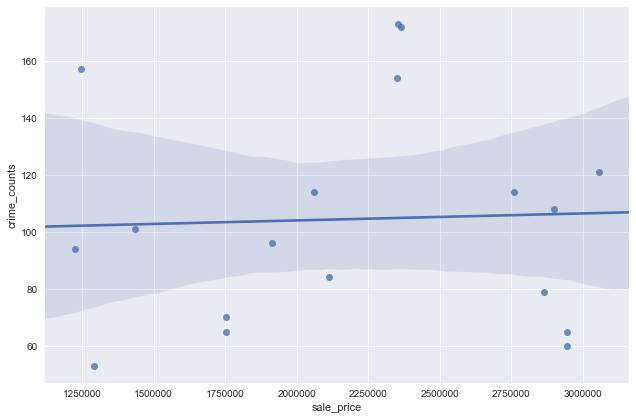

In [133]:
sns.set(color_codes=True)
ax = sns.lmplot(x='sale_price', y='crime_counts', data=salescrime, 
                scatter=True, 
                palette='Red', 
                size = 6,
                aspect = 1.5)